# Data Supplementation (suppl)

Method
1.	Identify identity terms with the most disproportionate data distributions 
    1. Stem/lemmatize dataset
    2. For each lemma in the synthetic test set:
        1. Check distribution across labels in dataset, i.e. difference between frequency in toxic comments and overall
        2.	Also check length differences!
    3. What does this mean exactly? 
        1.	“Identity terms affected by the false positive bias are disproportionately used in toxic comments in our training data. For example, the word ‘gay’ appears in 3% of toxic comments but only 0.5% of comments overall.”
        2.	Frequency of identity terms in toxic comments and overall: 
2.	Add additional non-toxic examples that contain the identity terms that appear disproportionately across labels in the original dataset
    1.	Use wiki data – assumed to be non-toxic
    2.	Add enough so that the balance is in line with the prior distribution for the overall dataset
        1.	E.g. until % “gay” in toxic comment is close to 0.50% as in overall data.
3.	Maybe consider different lengths as CNNs could be sensitive to this
    1.	“toxic comments tend to be shorter” (Dixon et al. 2018)
4.	Supposed to reduce false positives. Could also do the opposite? But more difficult to find toxic comments unless we take them from places that are supposedly toxic (e.g. “roast me”)


## Imports

In [1]:
# set cwd
import os
os.chdir("g:\\My Drive\\ITC, 5th semester (Thesis)\\Code\\Github_code\\toxicity_detection")

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacy import displacy
from tqdm import tqdm
from utils import load_dkhate
from typing import List, Dict
import pickle
import dacy
import utils
import nltk
import random
from wiki_scraper import scrape_wiki_text
tqdm.pandas()

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
def lemmatize_text(text:str) -> str:
    """Returns a lemmatized version of the text or itself if the string is empty."""
    if len(text) > 0:
        doc = nlp(text)
        lemmas = [token.lemma_ for token in doc]
        lemmatized_text = " ".join(lemmas)
        return lemmatized_text
    else:
        return text

def occurs_in_string(target:str, text:str) -> bool:
    """Checks whether a word occurs in a text."""
    for word in text.split():
        if word == target:
            return True
    return False

def calculate_nontoxic_to_add(f:float, n:int, t:int, method:str) -> int:
    """Calculate how many non-toxic examples you need to add to get the desired non-toxic fraction.

    Args:
        f (float): desired non-toxic fraction.
        n (int): current number of non-toxic examples.
        t (int): current number of toxic examples.
        method (str): method to convert result to int: "round", "ceiling", or "floor".

    Returns:
        int: number of non-toxic examples to add.    
    """
    a = (f*(t+n)-n) / (1-f)
    
    method = method.lower()
    if method == "round":
        return round(a)
    elif method == "ceiling":
        return int(np.ceil(a))
    elif method == "floor":
        return int(np.floor(a))
    else:
        raise Exception("Unknown method. Must be either 'round', 'ceiling', or 'floor'.")

def calculate_nontoxic_fraction(n:float, t:float, a:int) -> float:
    """Returns the fraction of non-toxic examples.

    Args:
        n (int): current number of non-toxic examples.
        t (int): current number of toxic examples.
        a (int): number of non-toxic examples to add.

    Returns:
        float: non-toxic fraction.
    """
    f = (n+a) / (t+n+a)
    return f

def occurs_in_list(target:str, text_list:List[str], return_idx:bool=False) -> bool:
    """Checks whether a word occurs in a list of texts/sentences."""
    for i, text in enumerate(text_list):
        if occurs_in_string(target, text):
            if return_idx:
                return True, i
            else:
                return True
    if return_idx:
        return False, None
    else:
        return False

def get_word_forms(lemma:str, identities:pd.DataFrame) -> List[str]:
    """Get all the word forms of a lemma, which appear in the identities dataframe."""
    return list(identities[identities["identity_lemma"]==lemma]["identity_term"])

def find_passages(passage_bank:List[str], word_list:List[str]) -> List[str]:
    """Outputs all the passages where any of the words in the word list occur.

    Args:
        passage_bank (List[str]): list of text passages.
        word_list (List[str]): list of words to find in the text passages.

    Returns:
        List[str]: list of text passages where at least one of the target words appear once.
    """
    result = []
    
    for sentence_list in passage_bank:
        for word in word_list:
            if occurs_in_list(target=word, text_list=sentence_list):
                result.append(sentence_list)
                break # don't need to add it twice
    
    return result

def scrape_random_pages(num:int) -> List[str]:
    """Scrape n random pages and return a list of the sections in these texts."""
    rd_sections = []
    for _ in range(num):
        content = scrape_wiki_text("https://da.wikipedia.org/wiki/Special:Random")
        for section in content:
            rd_sections.append(section)
    return rd_sections

def clean_scraped_sections(sections:List[str]) -> List[List[str]]:
    """Clean scraped sections and return a list of the sections, each compromised of a list of preprocessed sentences."""
    rd_section_bank = [] # bank of sections (each section is a list of cleaned sentences)
    for section in tqdm(sections):
        sentences = []
        if section.strip() != "": # error handling (empty strings are skipped)
            try: # otherwise "RuntimeError: The expanded size of the tensor ..." will appear in few cases. These will just be skipped.
                doc = nlp(section)
                for sent in doc.sents:
                    clean_sent = utils.preprocess(str(sent), stop_words)
                    if len(clean_sent) > 0: # don't add empty sentences
                        sentences.append(clean_sent)
                rd_section_bank.append(sentences)
            except:
                pass
    return rd_section_bank

def add_random_of_length(n_texts:int, num_random_to_add:Dict[str,int]) -> (List[str], Dict[str,int]):
    """Add random data that fulfill the length requirements specified in num_random_to_add.
    Returns the new texts and a dictionary of number texts we still need to add (equivalent to num_random_to_add).

    Args:
        n_texts (int): number of random texts to use.
        num_random_to_add (Dict[str,int]): key = length range, value = number of texts to add in this length range. 

    Returns:
        List[str]: list of random new samples.
        Dict[str,int]: key = length range, value = number of texts we still need to add in this length range. 
    """
    
    # scrape and preprocess random pages
    rd_sections = scrape_random_pages(n_texts)
    rd_section_bank = clean_scraped_sections(rd_sections)
    random.shuffle(rd_section_bank) # shuffle list, so we don't necessarily get everything from one article
    
    # pick texts in correct lengths to add
    # print message if we don't have enough texts of the correct length in the wikipedia text bank

    rd_new_samples = [] # store new samples
    still_need_to_add = {} # store how many samples we still need to add
    
    for length in tqdm(num_random_to_add): # for each length we need to deal with

        # range (length bucket)
        length_range = length.split("-")
        length_range = [int(l) for l in length_range]

        # number of ramdom examples to add
        num_to_add = num_random_to_add[length] # number new random to add
        
        # initialize variables
        num_added = 0

        # try with min n texts first
        for section in rd_section_bank: # for each section 
            
            if num_added < num_to_add: # only continue if we still need to add more sentences          
                
                # if the full section is within range, add that
                if length_range[0] <= len(' '.join(section)) <= length_range[1] and ' '.join(section) not in rd_new_samples:
                    rd_new_samples.append(' '.join(section))
                    rd_section_bank.remove(section) # remove section so we don't get duplicates in the results
                    num_added += 1

                # else add the sentence it occurs in, if it's of correct length
                else:
                    for sentence in section:
                        if length_range[0] <= len(sentence) <= length_range[1] and sentence not in rd_new_samples:
                            rd_new_samples.append(sentence)
                            rd_section_bank.remove(section)
                            num_added += 1
                            break

        if num_added < num_to_add:
            print(f"Not enough samples of the correct length within the text bank. Length: {length}, number to add: {num_to_add}, number added: {num_added}")
            still_need_to_add[length] = num_to_add-num_added # store how many samples we still need to add
        else:
            print(f"Enough samples. Length: {length}, number to add: {num_to_add}, number added: {num_added}")
    
    return rd_new_samples, still_need_to_add

## Load things

### Load DaCy model

In [3]:
# load daCy model (medium works fine)
nlp = dacy.load("da_dacy_medium_trf-0.2.0") # takes around 4 minutes the first time

In [4]:
# # test that it works as expected 
# doc = nlp("Mit navn er Maja. Jeg bor på Bispebjerg, men er fra Næstved.") 
# print("Token     \tLemma\t\tPOS-tag\t\tEntity type")
# for tok in doc: 
#     print(f"{str(tok).ljust(10)}:\t{str(tok.lemma_).ljust(10)}\t{tok.pos_}\t\t{tok.ent_type_}")
# displacy.render(doc, style="ent")

### Load preprocessed training data

In [5]:
# load data splits 
_, _, y_train_orig, _ = load_dkhate(test_size=0.2)
with open(os.getcwd()+"/data/X_orig_preproc.pkl", "rb") as f:
    content = pickle.load(f)

X_train_orig = content["X_train"]
train_orig = pd.DataFrame([X_train_orig, y_train_orig]).T
train_orig.tail()

,tweet,label
id,,
2378,hørt,0
1879,reaktion svensker,0
42,hey champ smide link ser hearthstone henne,0
457,melder vold voldtægt viser sandt beviser diver...,1
3108,betaler omkring mb kb får nok tættere kb kb be...,0


In [6]:
# lemmatize the texts (4-6 minutes)
train_orig["lemmas"] = train_orig["tweet"].progress_apply(lemmatize_text)

100%|██████████| 2631/2631 [03:42<00:00, 11.80it/s]


In [7]:
# split into toxic, non-toxic and all
toxic_text = train_orig[train_orig["label"] == 1]["lemmas"]
nontoxic_text = train_orig[train_orig["label"] == 0]["lemmas"]
all_text =  train_orig["lemmas"]

NUM_TOXIC = len(toxic_text)
NUM_NONTOXIC = len(nontoxic_text)
NUM_TOTAL = len(all_text)

toxic_text.head()

id
1174    scanne lortet pc markere tage underskrift ny d...
3301    kunne klarer fyr stort se venn vej samme spor ...
1390    fuck meget sol varme lille regn please dansk å...
799     hvorfor fucking stor helvede fejre kristn hell...
900     ingen udlænding ved grænse heller kriminell ku...
Name: lemmas, dtype: object

#### Oversampled

In [8]:
# with open(os.getcwd()+"/data/orig_dataset_splits.pkl", "rb") as f:
#     orig_oversampled = pickle.load(f)
# X_oversampl = orig_oversampled["X training preprocessed and oversampled"]
# y_oversampl = orig_oversampled["y training preprocessed and oversampled"]

In [9]:
# train_oversampl = pd.DataFrame([X_oversampl, y_oversampl]).T
# train_oversampl.rename(columns={"Unnamed 0": "tweet"}, inplace=True)
# train_oversampl

In [10]:
# # lemmatize the texts
# train_oversampl["lemmas"] = train_oversampl["tweet"].progress_apply(lemmatize_text)

In [11]:
# # split into toxic, non-toxic and all
# toxic_text_oversampl = train_oversampl[train_oversampl["label"] == 1]["lemmas"]
# nontoxic_text_oversampl = train_oversampl[train_oversampl["label"] == 0]["lemmas"]
# all_text_oversampl = train_oversampl["lemmas"]

# NUM_TOXIC_OVERSAMPL = len(toxic_text_oversampl)
# NUM_NONTOXIC_OVERSAMPL = len(nontoxic_text_oversampl)
# NUM_TOTAL_OVERSAMPL = len(all_text_oversampl)

# toxic_text_oversampl.head()

### Load identity terms

In [12]:
# load identity terms
identities = pd.read_excel(os.getcwd()+"/data/identity_terms.xlsx")
print(len(set(identities["identity_lemma"])), "unique identity lemmas")
identities.tail()

45 unique identity lemmas


,identity_term,identity_lemma
155,transpersonerne,transperson
156,transvestitterne,transvestit
157,transerne,trans
158,androgynerne,androgyn
159,hermafroditterne,hermafrodit


In [13]:
# lemmatize the identity terms (< 30 seconds)
identities["lemmatized"] = identities["identity_term"].progress_apply(lemmatize_text)
print(len(set(identities["lemmatized"])), "unique lemmatized identity terms")
identities.tail()

100%|██████████| 160/160 [00:06<00:00, 24.72it/s]

133 unique lemmatized identity terms


,identity_term,identity_lemma,lemmatized
155,transpersonerne,transperson,transperson
156,transvestitterne,transvestit,transvestitterne
157,transerne,trans,transe
158,androgynerne,androgyn,androgynerne
159,hermafroditterne,hermafrodit,hermafroditterne


In [14]:
# create map from lemmatized word to the actual lemma
lemmatized_2_lemma = dict(zip(identities["lemmatized"], identities["identity_lemma"]))

### Test scraper

In [15]:
content = scrape_wiki_text("https://da.wikipedia.org/wiki/Sankt_Mortens_Kirke_(N%C3%A6stved)")
print("_"*100)
for text in content:
    print(text)

Successfully scraped the webpage with the title: "Sankt Mortens Kirke (Næstved)"
____________________________________________________________________________________________________
55°13′47″N 11°45′39″Ø﻿ / ﻿55.2297°N 11.7608°Ø﻿ / 55.2297; 11.7608Koordinater: 55°13′47″N 11°45′39″Ø﻿ / ﻿55.2297°N 11.7608°Ø﻿ / 55.2297; 11.7608
Sankt Mortens Kirke er beliggende i Næstved centrum og er en af byens gamle middelalderkirker. Den er kendt fra en tidlig optegnelse omkring 1280, men menes at være bygget og taget i brug omkring 1200.

Kirken, der fra middelalderen blev bygget til at være byens sognekirke, mens de andre kirke var tættere knyttet til ordensvæsenet, er opkaldt efter den legendariske Sankt Martin af Tours, på dansk kaldt Sankt Morten.
Sankt Morten fejrer man i Danmark på Skt. Mortens aften den 10. november (Skt. Mortens Dag er den 11. november). Ifølge legenden ville Martin af Tours ikke udnævnes til biskop og gemte sig i en gåsesti. Gæssene afslørede ham ved deres høje skræppen, hvor

## Prepare for Data Supplemenation

### Frequency of identity terms
Find frequencies of lemmas in different subsets of the data (regardless of the length of the text).

In [16]:
# # test function
# print("This should return False. Result:", occurs_in_string("mor", "elsker din humor"))
# print("This should return True.  Result:", occurs_in_string("mor", "hans mor er pænt sød"))

In [17]:
# count how many texts these terms occur in
lemmatized_identities = list(set(identities["lemmatized"]))
occur_in_n_texts = {"lemmatized_identity": lemmatized_identities, "toxic_count": [], "nontoxic_count":[], "total_count":[]}

for lemma in lemmatized_identities:
    occur_in_n_texts["toxic_count"].append(toxic_text.apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum())
    occur_in_n_texts["nontoxic_count"].append(nontoxic_text.apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum())
    occur_in_n_texts["total_count"].append(all_text.apply(lambda x: (occurs_in_string(target=lemma, text=x))).sum())

In [18]:
# create df with these occurrence numbers
occurrence_df = pd.DataFrame(occur_in_n_texts)

# map back to actual lemma and aggregate duplicates
occurrence_df["lemma"] = occurrence_df["lemmatized_identity"].map(lemmatized_2_lemma)
occurrence_df = occurrence_df.groupby("lemma").agg({"toxic_count": "sum", "nontoxic_count": "sum", "total_count": "sum"}).reset_index()

# calculate percentages
occurrence_df["toxic_pct"] = (occurrence_df["toxic_count"]/NUM_TOXIC)*100 
occurrence_df["nontoxic_pct"] = (occurrence_df["nontoxic_count"]/NUM_NONTOXIC)*100 
occurrence_df["total_pct"] = (occurrence_df["total_count"]/NUM_TOTAL)*100 

# calculate differences
occurrence_df["tox_total_diff"] = occurrence_df["toxic_pct"] - occurrence_df["total_pct"]
occurrence_df["tox_total_abs_diff"] = abs(occurrence_df["toxic_pct"] - occurrence_df["total_pct"])

# sort by difference
sorted_occurrence_df = occurrence_df.sort_values("tox_total_diff", ascending=False).reset_index(drop=True)

# display rows where toxic pct != total pct
sorted_occurrence_df[sorted_occurrence_df["tox_total_diff"] != 0].round(2)

,lemma,toxic_count,nontoxic_count,total_count,toxic_pct,nontoxic_pct,total_pct,tox_total_diff,tox_total_abs_diff
0,mand,16,57,73,4.60,2.50,2.77,1.82,1.82
1,kvinde,7,26,33,2.01,1.14,1.25,0.76,0.76
2,fyr,1,0,1,0.29,0.00,0.04,0.25,0.25
3,mandfolk,1,0,1,0.29,0.00,0.04,0.25,0.25
4,queer,1,0,1,0.29,0.00,0.04,0.25,0.25
5,kvindfolk,1,0,1,0.29,0.00,0.04,0.25,0.25
6,tøs,1,0,1,0.29,0.00,0.04,0.25,0.25
7,søn,1,1,2,0.29,0.04,0.08,0.21,0.21
8,fætter,1,2,3,0.29,0.09,0.11,0.17,0.17
9,kone,2,9,11,0.57,0.39,0.42,0.16,0.16


In [19]:
# save this df
sorted_occurrence_df.to_excel(os.getcwd()+"/mitigation/frequency_of_identity_lemmas.xlsx")

The ones with a difference > 0 are the ones that I need to look at. 

I can actually make a difference here by adding non-toxic data and getting the toxic_pct number closer to the total_pct number, thereby reducing the difference so it's as close to zero as possible. 

#### Oversampled data

In [20]:
# # count how many texts these terms occur in
# occur_in_n_texts_oversampl = {"lemmatized_identity": lemmatized_identities, "toxic_count": [], "nontoxic_count":[], "total_count":[]}

# for lemma in lemmatized_identities:
#     occur_in_n_texts_oversampl["toxic_count"].append(toxic_text_oversampl.apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum())
#     occur_in_n_texts_oversampl["nontoxic_count"].append(nontoxic_text_oversampl.apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum())
#     occur_in_n_texts_oversampl["total_count"].append(all_text_oversampl.apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum())

In [21]:
# # create df with these occurrence numbers
# occurrence_df_oversampl = pd.DataFrame(occur_in_n_texts_oversampl)

# # map back to actual lemma and aggregate duplicates
# occurrence_df_oversampl["lemma"] = occurrence_df_oversampl["lemmatized_identity"].map(lemmatized_2_lemma)
# occurrence_df_oversampl = occurrence_df_oversampl.groupby("lemma").agg({"toxic_count": "sum", "nontoxic_count": "sum", "total_count": "sum"}).reset_index()

# # calculate percentages
# occurrence_df_oversampl["toxic_pct"] = (occurrence_df_oversampl["toxic_count"]/NUM_TOXIC_OVERSAMPL)*100 
# occurrence_df_oversampl["nontoxic_pct"] = (occurrence_df_oversampl["nontoxic_count"]/NUM_NONTOXIC_OVERSAMPL)*100 
# occurrence_df_oversampl["total_pct"] = (occurrence_df_oversampl["total_count"]/NUM_TOTAL_OVERSAMPL)*100 

# # calculate differences
# occurrence_df_oversampl["tox_total_diff"] = occurrence_df_oversampl["toxic_pct"] - occurrence_df_oversampl["total_pct"]
# occurrence_df_oversampl["tox_total_abs_diff"] = abs(occurrence_df_oversampl["toxic_pct"] - occurrence_df_oversampl["total_pct"])

# # sort by difference
# sorted_occurrence_df_oversampl = occurrence_df_oversampl.sort_values("tox_total_diff", ascending=False).reset_index(drop=True)

# # display rows where toxic pct != total pct
# sorted_occurrence_df_oversampl[sorted_occurrence_df_oversampl["tox_total_diff"] != 0].round(2)

In [22]:
# # save this df
# sorted_occurrence_df_oversampl.to_excel(os.getcwd()+"/mitigation/frequency_of_identity_lemmas_oversampl.xlsx")

The difference is that *dreng* is now in the top part (positive). Some differences are smaller, some are larger.

### Length differences

Percent of comments labeled as toxic at each length containing the given terms, e.g.:

| Term | 20-59 | 60-179 |
|:---:|:---:|:---:|
| ALL | 17% | 12% |
| gay | 88% | 77% |
| queer | 75% | 83% |
| ... | ... | ... |

Other lengths:
* 180-539
* 540-1619
* 1620-4859


Method:

* For each lemma:
  * Find the texts that it occur in
  * Separate these texts into 5 length buckets
  * For each length_bucket:
    * Find the percentage that are toxic

In [23]:
# add lengths to train df
train_orig["length"] = train_orig["tweet"].progress_apply(lambda x: len(x))

# divide train data into 6 buckets
print("Min length:", train_orig["length"].min())
print("Max length:", train_orig["length"].max())

bin1 = train_orig.query("0 <= length <= 59") # 60 (orig had 0-19 and 20-59, but difficult to find data under 19 chars)
bin2 = train_orig.query("60 <= length <= 179") # 120
bin3 = train_orig.query("180 <= length <= 419") # 240
bin4 = train_orig.query("420 <= length <= 899") # 480
bin5 = train_orig.query("900 <= length") # the rest
bins = [bin1, bin2, bin3, bin4, bin5]
bin_labels = ["0-59", "60-179", "180-419", "420-899", "900-3519"]

100%|██████████| 2631/2631 [00:00<00:00, 585546.74it/s]

Min length: 0
Max length: 3518


In [24]:
# find proportion of toxic comments for each bin (no specific terms)
results = {"bin_range":bin_labels, "toxic":[], "nontoxic":[]}
for bin in bins: # length bins
    results["toxic"].append(len(bin[bin["label"] == 1])) # count toxic in that bin
    results["nontoxic"].append(len(bin[bin["label"] == 0])) # and non-toxic

# prepare preliminary results df
prel_results_df = pd.DataFrame(results)
prel_results_df["pct_toxic"] = ( prel_results_df["toxic"] / (prel_results_df["toxic"]+prel_results_df["nontoxic"]) ) * 100 # add percentage
prel_results_df.set_index("bin_range", inplace=True)

# add to final results df
results_df_1 = prel_results_df[["pct_toxic"]].T
results_df_1.index = ["ALL"]
results_df_1.round(2)

bin_range,0-59,60-179,180-419,420-899,900-3519
ALL,12.04,13.86,21.67,35.29,20.0


In [25]:
# do the same for each lemma

# prepare dicts
toxic_count_dict = {"lemmatized_identity": lemmatized_identities}
total_count_dict = {"lemmatized_identity": lemmatized_identities}
for label in bin_labels:
    toxic_count_dict[label] = []
    total_count_dict[label] = []
    
for lemma in lemmatized_identities: # for each lemma
    for (bin_label, bin) in zip(bin_labels, bins): # for each bin
        
        # count no. of toxic/all texts this lemma occurs in in this bin
        toxic_count = bin[bin["label"]==1]["lemmas"].apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum() 
        total_count = bin["lemmas"].apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum() 
        
        # add to count_dicts
        toxic_count_dict[bin_label].append(toxic_count)
        total_count_dict[bin_label].append(total_count)

In [26]:
# create df with these occurrence numbers
toxic_count_df = pd.DataFrame(toxic_count_dict)
total_count_df = pd.DataFrame(total_count_dict)

# map back to actual lemma and aggregate duplicates
toxic_count_df["lemma"] = toxic_count_df["lemmatized_identity"].map(lemmatized_2_lemma)
toxic_count_df = toxic_count_df.groupby("lemma").agg({"0-59": "sum", "60-179": "sum", "180-419": "sum", "420-899": "sum", "900-3519": "sum"}).reset_index()
toxic_count_df["sum"] = toxic_count_df["0-59"] + toxic_count_df["60-179"] + toxic_count_df["180-419"] + toxic_count_df["420-899"] + toxic_count_df["900-3519"]
toxic_count_df = toxic_count_df.sort_values("lemma")
total_count_df["lemma"] = total_count_df["lemmatized_identity"].map(lemmatized_2_lemma)
total_count_df = total_count_df.groupby("lemma").agg({"0-59": "sum", "60-179": "sum", "180-419": "sum", "420-899": "sum", "900-3519": "sum"}).reset_index()
total_count_df["sum"] = total_count_df["0-59"] + total_count_df["60-179"] + total_count_df["180-419"] + total_count_df["420-899"] + total_count_df["900-3519"]
total_count_df = total_count_df.sort_values("lemma")

In [27]:
# add to results df
results_df_2 = toxic_count_df[["lemma"]]
for col in toxic_count_df.columns[1:-1]:
    results_df_2[col] = (toxic_count_df[col] / total_count_df[col]) * 100 # calculate percentages
results_df_2.set_index("lemma", inplace=True)

In [28]:
# show final df
results_df = pd.concat([results_df_1, results_df_2])
results_df.dropna(axis = 0, how = 'all', inplace = True) # drop rows with all NA values
display(results_df.round(2).fillna("")) # show results

# save results
results_df = results_df.fillna("") # fill NAs
results_df.to_excel(os.getcwd()+"/mitigation/toxicity_at_diff_lengths.xlsx") # save as xlsx file

,0-59,60-179,180-419,420-899,900-3519
ALL,12.04,13.86,21.67,35.29,20.0
bror,0.0,0.0,0.0,0.0,50.0
dame,,0.0,0.0,,
datter,,0.0,0.0,0.0,0.0
dreng,100.0,0.0,,,0.0
far,0.0,0.0,100.0,,0.0
fyr,,100.0,,,
fætter,0.0,,100.0,0.0,
herre,0.0,0.0,,,
kone,0.0,0.0,0.0,100.0,0.0


### Calculate how much new data is needed
Based on:
https://github.com/conversationai/unintended-ml-bias-analysis/blob/main/archive/unintended_ml_bias/Dataset_bias_analysis.ipynb

In [29]:
## Pseudocode
# num_nontoxic_to_add = {}

# for word in list_of_words_to_fix:
#   for length:
#       t = get t from toxic_count_df
#       n = get n from total_count_df - t
#       f = get from results_df.loc[ALL, bin_label]
#       a = calculate_nontoxic_to_add(f=f, n=n, t=t, method="round")
#       num_nontoxic_to_add[word] = a

In [30]:
# # example (mand 140-?)
# t = 6 # current number of toxic examples
# n = 18 # current number of non-toxic examples
# a = calculate_nontoxic_to_add(f=0.825, n=n, t=t, method="round")
# f = calculate_nontoxic_fraction(n=n, t=t, a=a) # new toxic fraction

# print("Old non-toxic fraction  :", round(calculate_nontoxic_fraction(n=n, t=t, a=0), 4))
# print("Add n non-toxic examples:", a)
# print("New non-toxic fraction  :", round(calculate_nontoxic_fraction(n=n, t=t, a=a), 4))

In [31]:
# find words to fix
overall_prior_distributions = results_df.iloc[0, :] 
lengths = overall_prior_distributions.keys()
unbalanced_lemmas_at_lengths = {}

print("LEMMA\t\tLENGTH\t\tTOXIC%")
for row in results_df.iloc[1:,:].iterrows(): # for each unbalanced row
    lemma = row[0]
    content = row[1]
    
    unbalanced_lengths = []
    for i, x in enumerate(content): # for each column (= length bucket)
        if type(x) == float and x > overall_prior_distributions.iloc[i]: # if the percentage of toxic is larger than the prior distribution 
            print(f"{lemma.ljust(9)}\t{lengths[i].ljust(8)}\t{x:6.2f} %") 
            unbalanced_lengths.append(lengths[i])        
    if unbalanced_lengths: # if not empty
        unbalanced_lemmas_at_lengths[lemma] = unbalanced_lengths

LEMMA		LENGTH		TOXIC%
bror     	900-3519	 50.00 %
dreng    	0-59    	100.00 %
far      	180-419 	100.00 %
fyr      	60-179  	100.00 %
fætter   	180-419 	100.00 %
kone     	420-899 	100.00 %
kvinde   	60-179  	 20.00 %
kvinde   	180-419 	 50.00 %
kvindfolk	420-899 	100.00 %
mand     	60-179  	 38.89 %
mand     	180-419 	 27.78 %
mandfolk 	0-59    	100.00 %
mor      	60-179  	 25.00 %
pige     	60-179  	 33.33 %
queer    	900-3519	100.00 %
søn      	60-179  	 50.00 %
tøs      	0-59    	100.00 %


In [32]:
# display words to fix
unbalanced_lemmas_at_lengths

{'bror': ['900-3519'],
 'dreng': ['0-59'],
 'far': ['180-419'],
 'fyr': ['60-179'],
 'fætter': ['180-419'],
 'kone': ['420-899'],
 'kvinde': ['60-179', '180-419'],
 'kvindfolk': ['420-899'],
 'mand': ['60-179', '180-419'],
 'mandfolk': ['0-59'],
 'mor': ['60-179'],
 'pige': ['60-179'],
 'queer': ['900-3519'],
 'søn': ['60-179'],
 'tøs': ['0-59']}

In [33]:
# find the value "a" for each unbalanced lemma at length

num_nontoxic_to_add = {}
old_new_nontoxic_frac = {}
total_to_add = 0

for lemma in unbalanced_lemmas_at_lengths: # for word in list_of_words_to_fix:
    
    for length in unbalanced_lemmas_at_lengths[lemma]: # for length
    
        current_toxic = toxic_count_df[toxic_count_df["lemma"]==lemma][length].iloc[0] #  t = get t from toxic_count_df
        current_total = total_count_df[total_count_df["lemma"]==lemma][length].iloc[0]
        current_nontoxic = current_total - current_toxic # n = get n from total_count_df - t
        desired_f = 1 - (overall_prior_distributions[length]/100) # f = 1 - toxic frac (get this from overall_prior_distributions/100 (results_df.loc[ALL, bin_label]))
        add_n_nontoxic = calculate_nontoxic_to_add(f=desired_f, n=current_nontoxic, t=current_toxic, method="ceiling")
        
        num_nontoxic_to_add[(lemma, length)] = add_n_nontoxic
        new_f = calculate_nontoxic_fraction(n=current_nontoxic, t=current_toxic, a=add_n_nontoxic)
        old_new_nontoxic_frac[(lemma, length)] = (desired_f, new_f)
        total_to_add += add_n_nontoxic
print("Done")
print("Total to add:", total_to_add, "samples =", round((total_to_add/len(train_orig)*100),2), "%")

Done
Total to add: 121 samples = 4.6 %


In [34]:
# display results
print("(lemma, length): number to add")
num_nontoxic_to_add

(lemma, length): number to add


{('bror', '900-3519'): 4,
 ('dreng', '0-59'): 8,
 ('far', '180-419'): 4,
 ('fyr', '60-179'): 7,
 ('fætter', '180-419'): 4,
 ('kone', '420-899'): 4,
 ('kvinde', '60-179'): 5,
 ('kvinde', '180-419'): 8,
 ('kvindfolk', '420-899'): 2,
 ('mand', '60-179'): 33,
 ('mand', '180-419'): 6,
 ('mandfolk', '0-59'): 8,
 ('mor', '60-179'): 4,
 ('pige', '60-179'): 5,
 ('queer', '900-3519'): 5,
 ('søn', '60-179'): 6,
 ('tøs', '0-59'): 8}

In [35]:
# display old and new nontoxic fraction
old_new_nontoxic_frac_df = pd.DataFrame(old_new_nontoxic_frac).T
old_new_nontoxic_frac_df.rename(columns={0:"old_f", 1:"new_f"}, inplace=True)
old_new_nontoxic_frac_df.round(4)

old_f   new_f
bror      900-3519  0.8000  0.8333
dreng     0-59      0.8796  0.8889
far       180-419   0.7833  0.8000
fyr       60-179    0.8614  0.8750
fætter    180-419   0.7833  0.8000
kone      420-899   0.6471  0.6667
kvinde    60-179    0.8614  0.8667
          180-419   0.7833  0.7857
kvindfolk 420-899   0.6471  0.6667
mand      60-179    0.8614  0.8627
          180-419   0.7833  0.7917
mandfolk  0-59      0.8796  0.8889
mor       60-179    0.8614  0.8750
pige      60-179    0.8614  0.8750
queer     900-3519  0.8000  0.8333
søn       60-179    0.8614  0.8750
tøs       0-59      0.8796  0.8889

## Perform Data Supplemenation

In [36]:
# now:
# for each word to add:
    # find page that mentions this word
    # scrape this page
    # add text to big text bank

# for each word to add:
    # search in text bank for passages that mentions this lemma
    # extract these passages and divide them into sentences
    # preprocess said passages
    # if one matches the given length bucket, add it
    # otherwise, go into sentences. if one of these match, then add it. otherwise, add this sentence + surrounding sentences until we get the desired length.

# add to training data

Search on wiki:

- advanced search
- one of these words: the four variants, e.g. "bror, broren, brødre, brødrene"
- these categories: "biografier", "filmskolefilm fra Danmark", "sange fra Danmark" # BECAUSE MORE GENERAL CATEGORIES THROWS ERROR
- sorted by relevance
- top 1 result from each category
- only difference is queer that had no results in these categories, so had to just search for "queer" and use three random pages (undgik hoved/definitionssiden)

bror:
- https://da.wikipedia.org/wiki/Hemming_Hartmann-Petersen
- https://da.wikipedia.org/wiki/Zafir_(film_fra_2011)
- https://da.wikipedia.org/wiki/Brdr._Gebis

dreng
- https://da.wikipedia.org/wiki/Mogens_Wenzel_Andreasen
- https://da.wikipedia.org/wiki/Dreng_(dokumentarfilm)
- https://da.wikipedia.org/wiki/We_Wanna_Be_Free 

far
- https://da.wikipedia.org/wiki/Christian_Molbech # not top result, because it was a different word "fædrene tro" that was the hit
- https://da.wikipedia.org/wiki/Vore_F%C3%A6dres_S%C3%B8nner
- https://da.wikipedia.org/wiki/Ebbe_Skammels%C3%B8n # is this toxic? "kvæste sin far"

fyr
- XX MANGLER, SE KOMMENTAR NEDENFOR
    - https://da.wikipedia.org/wiki/John_Green_(forfatter) (søgte på "en ung fyr")
- https://da.wikipedia.org/wiki/LUCK.exe
- https://da.wikipedia.org/wiki/Du_G%C3%B8r_Mig # not the first as the others were about "FYR OG FLAMME

fætter
- https://da.wikipedia.org/wiki/Eleonore_Tscherning 
- INGEN MED FILM ELLER SANGE, DERFOR BARE TO FRA GENEREL SØGNING
    - https://da.wikipedia.org/wiki/F%C3%A6tter_H%C3%B8jben
    - https://da.wikipedia.org/wiki/Min_f%C3%A6tter_er_pirat

kone
- https://da.wikipedia.org/wiki/Ralf_Pittelkow
- https://da.wikipedia.org/wiki/Deadline_(film_fra_2005) (ikke første, her var det en titel)
- https://da.wikipedia.org/wiki/Krig_og_fred_(Shu-bi-dua)

kvinde
- https://da.wikipedia.org/wiki/Thora_Esche
- https://da.wikipedia.org/wiki/Kvinden_(film)
- https://da.wikipedia.org/wiki/Danske_sild_(Shu-bi-dua-sang)

kvindfolk
- ingen hits i de tre kategorier, derfor bare fra generel søgning
    - https://da.wikipedia.org/wiki/G%C3%A5rd_fra_Pebringe,_Sj%C3%A6lland_(Frilandsmuseet)
    - https://da.wikipedia.org/wiki/Sophie_Caroline_af_Ostfriesland
    - https://da.wikipedia.org/wiki/Hospital

mand
- https://da.wikipedia.org/wiki/J.J._Dampe (ikke den første, fordi ordet kun optrådte i titler/værker der)
- https://da.wikipedia.org/wiki/Manden_der_dr%C3%B8mte_at_han_v%C3%A5gnede
- https://da.wikipedia.org/wiki/St%C3%A5r_p%C3%A5_en_alpetop

mandfolk
- ingen hits i de tre kategorier, derfor bare fra generel søgning (mange af disse var bare filmtitler, dvs. ikke sætninger)
    - https://da.wikipedia.org/wiki/Louis_Marcussen
    - https://da.wikipedia.org/wiki/Asterix_og_vikingerne_(tegnefilm)
    - https://da.wikipedia.org/wiki/Lysets_rige

mor
- https://da.wikipedia.org/wiki/S%C3%B8sser_Krag
- https://da.wikipedia.org/wiki/Kokon_(film_fra_2019)
- https://da.wikipedia.org/wiki/Germand_Gladensvend (skippede dem vi havde allerede)

pige
- https://da.wikipedia.org/wiki/Jean-Paul_Sartre (samme som med sangen)
- https://da.wikipedia.org/wiki/Forl%C3%B8sning
- https://da.wikipedia.org/wiki/Den_danske_sang_er_en_ung,_blond_pige (første var kun titel)

queer:
- https://da.wikipedia.org/wiki/Warehouse9 (culture)
- https://da.wikipedia.org/wiki/Babylebbe (movie)
- https://da.wikipedia.org/wiki/Judith_Butler (person)

søn
- https://da.wikipedia.org/wiki/Christian_8.
- https://da.wikipedia.org/wiki/F%C3%A6dreland_(film) (skippede dem vi havde allerede)
- https://da.wikipedia.org/wiki/Titte_til_hinanden (skippede dem vi havde allerede)

tøs
- https://da.wikipedia.org/wiki/Stephanie_Le%C3%B3n (samme som ved sangen)
- https://da.wikipedia.org/wiki/13_snart_30 (film tilladt for alle, da ingen hits ellers)
- https://da.wikipedia.org/wiki/T%C3%A6t_p%C3%A5_-_live (generel søgning, for få hits ved specifik søgning)


cannot find a biography that uses the word "fyr". mostly slang. can only find ones that use "fyret" (e.g. "fyret fra sit arbejde") or "fyrre"


**Decided to add more for the words where len(passage) or len(sentence) was not enough (just from general search)**

In [37]:
urls = [
    "https://da.wikipedia.org/wiki/Hemming_Hartmann-Petersen",
    "https://da.wikipedia.org/wiki/Zafir_(film_fra_2011)",
    "https://da.wikipedia.org/wiki/Brdr._Gebis",
    "https://da.wikipedia.org/wiki/Mogens_Wenzel_Andreasen",
    "https://da.wikipedia.org/wiki/Dreng_(dokumentarfilm)",
    "https://da.wikipedia.org/wiki/We_Wanna_Be_Free",
    "https://da.wikipedia.org/wiki/Christian_Molbech",
    "https://da.wikipedia.org/wiki/Vore_F%C3%A6dres_S%C3%B8nner",
    "https://da.wikipedia.org/wiki/Ebbe_Skammels%C3%B8n",
    "https://da.wikipedia.org/wiki/John_Green_(forfatter)",
    "https://da.wikipedia.org/wiki/LUCK.exe",
    "https://da.wikipedia.org/wiki/Du_G%C3%B8r_Mig",
    "https://da.wikipedia.org/wiki/Eleonore_Tscherning",
    "https://da.wikipedia.org/wiki/F%C3%A6tter_H%C3%B8jben",
    "https://da.wikipedia.org/wiki/Min_f%C3%A6tter_er_pirat",
    "https://da.wikipedia.org/wiki/Ralf_Pittelkow",
    "https://da.wikipedia.org/wiki/Deadline_(film_fra_2005)",
    "https://da.wikipedia.org/wiki/Krig_og_fred_(Shu-bi-dua)",
    "https://da.wikipedia.org/wiki/Thora_Esche",
    "https://da.wikipedia.org/wiki/Kvinden_(film)",
    "https://da.wikipedia.org/wiki/Danske_sild_(Shu-bi-dua-sang)",
    "https://da.wikipedia.org/wiki/G%C3%A5rd_fra_Pebringe,_Sj%C3%A6lland_(Frilandsmuseet)",
    "https://da.wikipedia.org/wiki/Sophie_Caroline_af_Ostfriesland",
    "https://da.wikipedia.org/wiki/Hospital",
    "https://da.wikipedia.org/wiki/J.J._Dampe",
    "https://da.wikipedia.org/wiki/Manden_der_dr%C3%B8mte_at_han_v%C3%A5gnede",
    "https://da.wikipedia.org/wiki/St%C3%A5r_p%C3%A5_en_alpetop",
    "https://da.wikipedia.org/wiki/Louis_Marcussen", # no hit
    "https://da.wikipedia.org/wiki/Asterix_og_vikingerne_(tegnefilm)", # hit
    "https://da.wikipedia.org/wiki/Lysets_rige", # no hit
    "https://da.wikipedia.org/wiki/S%C3%B8sser_Krag",
    "https://da.wikipedia.org/wiki/Kokon_(film_fra_2019)",
    "https://da.wikipedia.org/wiki/Germand_Gladensvend",
    "https://da.wikipedia.org/wiki/Jean-Paul_Sartre",
    "https://da.wikipedia.org/wiki/Forl%C3%B8sning",
    "https://da.wikipedia.org/wiki/Den_danske_sang_er_en_ung,_blond_pige",
    "https://da.wikipedia.org/wiki/Warehouse9",
    "https://da.wikipedia.org/wiki/Babylebbe",
    "https://da.wikipedia.org/wiki/Judith_Butler",
    "https://da.wikipedia.org/wiki/Christian_8.",
    "https://da.wikipedia.org/wiki/F%C3%A6dreland_(film)",
    "https://da.wikipedia.org/wiki/Titte_til_hinanden",
    "https://da.wikipedia.org/wiki/Stephanie_Le%C3%B3n",
    "https://da.wikipedia.org/wiki/13_snart_30",
    "https://da.wikipedia.org/wiki/T%C3%A6t_p%C3%A5_-_live", # hit
    
    # newly added (5 random from general search for lemmas that still need extra data)
    "https://da.wikipedia.org/wiki/Der_var_engang_en_dreng",
    "https://da.wikipedia.org/wiki/Niels_Pind_og_hans_dreng",
    "https://da.wikipedia.org/wiki/Smukke_dreng",
    "https://da.wikipedia.org/wiki/Portr%C3%A6t_af_en_dreng",
    "https://da.wikipedia.org/wiki/Drengen",
    "https://da.wikipedia.org/wiki/Clint_Eastwood",
    "https://da.wikipedia.org/wiki/Winfield_Scott",
    "https://da.wikipedia.org/wiki/Sara_Bl%C3%A6del",
    "https://da.wikipedia.org/wiki/David_Firth",
    "https://da.wikipedia.org/wiki/Stephen_Dorff",
    "https://da.wikipedia.org/wiki/F%C3%A6tter_Vims",
    "https://da.wikipedia.org/wiki/F%C3%A6tter_Guf",
    "https://da.wikipedia.org/wiki/F%C3%A6tter_BR",
    "https://da.wikipedia.org/wiki/Agamemnon",
    "https://da.wikipedia.org/wiki/Brylluppet_mellem_kronprinsesse_Victoria_og_Daniel_Westling",
    "https://da.wikipedia.org/wiki/En_n%C3%B8gen_kvinde_s%C3%A6tter_sit_h%C3%A5r_foran_et_spejl",
    "https://da.wikipedia.org/wiki/Kvinders_valgret",
    "https://da.wikipedia.org/wiki/EM_i_fodbold_2022_(kvinder)",
    "https://da.wikipedia.org/wiki/En_duft_af_kvinde",
    "https://da.wikipedia.org/wiki/Kvindernes_internationale_kampdag",
    "https://da.wikipedia.org/wiki/Olivia_Levison",
    "https://da.wikipedia.org/wiki/Lofotenfiskeriets_historie",
    "https://da.wikipedia.org/wiki/Broder_Rus",
    "https://da.wikipedia.org/wiki/S%C3%B8ren_Nielsen_May",
    "https://da.wikipedia.org/wiki/Nerthus",
    "https://da.wikipedia.org/wiki/Friederich_M%C3%BCnter",
    "https://da.wikipedia.org/wiki/Den_tavse_mand",
    "https://da.wikipedia.org/wiki/En_mand_kommer_hjem",
    "https://da.wikipedia.org/wiki/Orvar-Odd",
    "https://da.wikipedia.org/wiki/Apollo-programmet",
    
    # changed some of them for "mandfolk", "queer" and "tøs" to get correctt # of hits
    "https://da.wikipedia.org/wiki/Et_rigtigt_Mandfolk", # mandfolk hit
    "https://da.wikipedia.org/wiki/De_dumme_Mandfolk", # mandfolk hit
    "https://da.wikipedia.org/wiki/Nina_Bang", # mandfolk hit
    "https://da.wikipedia.org/wiki/Et_Pr%C3%A6riens_Mandfolk", # mandfolk hit
    "https://da.wikipedia.org/wiki/%C3%85h,_de_mandfolk!", # mandfolk hit
    "https://da.wikipedia.org/wiki/Olsenbandens_aller_siste_kupp", # mandfolk hit
    "https://da.wikipedia.org/wiki/I_kantonnement", # mandfolk hit
    
    "https://da.wikipedia.org/wiki/Dan_Levy_(skuespiller)", # no hit
    "https://da.wikipedia.org/wiki/Heidi_Mortenson", # no hit
    "https://da.wikipedia.org/wiki/Joe_Lycett", # no hit
    "https://da.wikipedia.org/wiki/Aidan_Gillen", # queer hit
    "https://da.wikipedia.org/wiki/P%C3%A6dagogisk_filosofi", # queer hit
    
    "https://da.wikipedia.org/wiki/En_pokkers_T%C3%B8s", # tøs hit
    "https://da.wikipedia.org/wiki/Kate_Walsh", # tøs hit
    "https://da.wikipedia.org/wiki/Jack_Sparrow", # tøs hit
    "https://da.wikipedia.org/wiki/Des_Knaben_Wunderhorn_(Mahler)", # tøs hit
    "https://da.wikipedia.org/wiki/Steen_%26_Stoffer", # tøs hit
    "https://da.wikipedia.org/wiki/Fiktive_personer_i_Lost", # tøs hit
    "https://da.wikipedia.org/wiki/Nis_Petersen", # tøs hit
    
    # same for "bror" and "queer"
    "https://da.wikipedia.org/wiki/Harald_2", # bror hit
    "https://da.wikipedia.org/wiki/Demeter_(gudinde)", # bror hit
    "https://da.wikipedia.org/wiki/Moses", # bror hit
    "https://da.wikipedia.org/wiki/Janelle_Mon%C3%A1e", # queer hit
    "https://da.wikipedia.org/wiki/Taylor_Swift" # queer hit
]

print(len(urls), "urls")

99 urls


### Scrape from wikipedia

1) Search for pages to add (manually selected)
2) Scrape these pages using requests and beautifulsoup4
3) Concatenate to one big text bank
4) Search for word forms in this text bank. Extract the needed number of texts in the correct length.
5) Train model on the new dataset and do bias analysis

Afterwards, try to do both types of mitigation on the oversampled dataset

OR 

Try to rerun the original model on non-oversampled dataset
ASK MANEX!

In [38]:
# scrape webpages
sections = []

for url in urls:
    content = scrape_wiki_text(url)
    for section in content:
        sections.append(section)

Successfully scraped the webpage with the title: "Hemming Hartmann-Petersen"
Successfully scraped the webpage with the title: "None"
Successfully scraped the webpage with the title: "Brdr. Gebis"
Successfully scraped the webpage with the title: "Mogens Wenzel Andreasen"
Successfully scraped the webpage with the title: "None"
Successfully scraped the webpage with the title: "We Wanna Be Free"
Successfully scraped the webpage with the title: "Christian Molbech"
Successfully scraped the webpage with the title: "Vore Fædres Sønner"
Successfully scraped the webpage with the title: "Ebbe Skammelsøn"
Successfully scraped the webpage with the title: "John Green (forfatter)"
Successfully scraped the webpage with the title: "LUCK.exe"
Successfully scraped the webpage with the title: "Du Gør Mig"
Successfully scraped the webpage with the title: "Eleonore Tscherning"
Successfully scraped the webpage with the title: "Fætter Højben"
Successfully scraped the webpage with the title: "Min fætter er pir

In [39]:
# pseudocode

# split passages into sentences
# preprocess passage bank

# for (lemma, length) in num_nontoxic_to_add
    # num_to_add = num_nontoxic_to_add[(lemma, length)]
    # map from lemmas to word forms using get_word_forms

    # call function that loops through passage bank and outputs n passages where this words occur (find passages)

In [40]:
# # test check occurrences 
# for passage in passages[:9]:
#     occurs = False
#     for word in passage.split():
#         if word == "bror":
#             occurs = True
#     if occurs == True:
#         print("bror")
#         print(passage)

In [41]:
# # test getting word forms 
# print("lemmatized:", list(identities[identities["identity_lemma"]=="trans"]["lemmatized"]))
# print("word forms:", list(identities[identities["identity_lemma"]=="trans"]["identity_term"]))

In [42]:
# # test fuctions

# print(occurs_in_list("bror", ["min søster er stolt", "det er hendes mor ikke"]))
# print(occurs_in_list("bror", ["min søster er stolt", "det er hendes mor ikke", "jeg elsker min bror højt"], True))

# get_word_forms("trans", identities)

In [43]:
# # test breaking in nested loops
# for y in [[1,-1],[2,2,3,2],[3,2,3],[2]]:
#     print("Y = ", y)
#     for x in y:
#         print("X =", x)
#         if x == 2:
#             print("                two found")
#             break
#         # print("!")

In [44]:
# # test splitting into sentences

# doc = nlp('Det her er en sætning. Det her er endnu en sætning, hihi.')
# for sent in doc.sents:
#     print(sent)

In [45]:
# split passages into sentences and preprocess (15-30 minutes)

stop_words = nltk.corpus.stopwords.words('danish')
section_bank = clean_scraped_sections(sections)

# passage_bank = []
# for passage in tqdm(passages):
#     sentences = []
#     if passage.strip() != "":
#         doc = nlp(passage)
#         for sent in doc.sents:
#             clean_sent = utils.preprocess(str(sent), stop_words)
#             if len(clean_sent) > 0: # don't add empty strings
#                 sentences.append(clean_sent)
#         passage_bank.append(sentences)

  0%|          | 1/1578 [00:00<04:34,  5.75it/s]

100%|██████████| 1578/1578 [16:45<00:00,  1.57it/s] 


In [46]:
print(len(section_bank), "sections in the text bank")

1519 sections in the text bank


In [47]:
# # test function
# find_passages(passage_bank[:9], ["bror"])

In [59]:
sum(num_nontoxic_to_add.values())

121

In [66]:
# pick texts in correct lengths to add
# an error message is printed for each lemma, where we don't have enough texts of the correct length in the wikipedia text bank

# a risk is that the same sample is added twice (for different lemmas or lengths). Therefore, I added code that checks whether it has already been added. 

new_samples = [] # store new samples
# n_added = {} # store how many were added in each bin

for (lemma, length) in tqdm(num_nontoxic_to_add): # for each lemma and length we need to deal with

    # range (length bucket)
    length_range = length.split("-")
    length_range = [int(l) for l in length_range]

    # number of nontoxic examples to add
    num_to_add = num_nontoxic_to_add[(lemma, length)] # number new nontoxic to add

    # word forms
    word_list = get_word_forms(lemma, identities) # word forms

    # find sections that the words appear in
    sections = find_passages(section_bank, word_list)
    random.shuffle(sections) # shuffle sections
    
    # initialize variables
    num_added = 0

    for section in sections: # for each section where the lemma appears
        
        if num_added < num_to_add: # only continue if we still need to add more sentences          
            sentence_lengths = [len(sent)+1 for sent in section] # +1 = space between sentences
            
            # if the full section is within range, add that
            if length_range[0] <= len(' '.join(section)) <= length_range[1] and ' '.join(section) not in new_samples:
                #print(type(section), section)
                new_samples.append(' '.join(section))
                num_added += 1

            # else add the sentence it occurs in, if it's of correct length
            else:
                for sentence in section:
                    if any(occurs_in_string(word, sentence) for word in word_list):
                        if length_range[0] <= len(sentence) <= length_range[1] and sentence not in new_samples:
                            new_samples.append(sentence)
                            num_added += 1
                            break
    
    # n_added[(lemma, length)] = num_added
    if num_added < num_to_add:
        print(f"Not enough samples of the correct length within the text bank, try to add more data or change the desired length.\n\tlemma: {lemma}, length: {length}\n\tnumber to add: {num_to_add}, number added: {num_added}")

100%|██████████| 17/17 [00:00<00:00, 54.50it/s]

Not enough samples of the correct length within the text bank, try to add more data or change the desired length.
	lemma: queer, length: 900-3519
	number to add: 5, number added: 4


In [67]:
# it is not possible to get long enough quotes from any of the wikipedia articles (tried every search hit for this lemma)

# therefore, I'll concatenate sections from another wiki article to get a long enough section to add

extra_sections = [section for section in scrape_wiki_text("https://da.wikipedia.org/wiki/Heidi_Mortenson")]
extra_section_bank = clean_scraped_sections(extra_sections)
extra_section_bank = [' '.join(section) for section in extra_section_bank] # doens't need to be split into sentences

# get idx of section that queer first appear in
occur_idx = None
for i, s in enumerate(extra_section_bank):
    if occurs_in_string("queer", s):
        occur_idx = i
        break

# add next section until it's long enough
queer_str = extra_section_bank[occur_idx]
for i in range(occur_idx, len(extra_section_bank)):
    i += 1
    if len(queer_str) < 900:
        queer_str += extra_section_bank[i]
print("Length of string:", len(queer_str), "chars")

new_samples.append(queer_str)

Successfully scraped the webpage with the title: "Heidi Mortenson"


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]

Length of string: 1001 chars


In [68]:
print(len(new_samples), "new samples added out of the", total_to_add, "that should be added.")
assert len(new_samples) == total_to_add
print("\nFive new samples:")
for sample in new_samples[:5]:
    print(" - ", sample)

121 new samples added out of the 121 that should be added.

Five new samples:
 -  udarbejdede albert haelwegh serie portrætter danske konger sagnkongen dan frem christian iv samlet værket regum daniæ icones gengives muligvis første gang portræt harald ii konge nr serie angivne regeringslængde angivne dødsår afviger del ved harald egentlig vist bare tale tilfælde sjusk harald ii blevet udstyret samme regeringslængde samme dødsår farfar harald blåtand ser række yderligere portrætfremstillinger danske konger udgivet århundrede så indtrykket harald ii helt mangler henved halvdelen portrætsamlinger levnedsbeskrivelser så udfordringen få harald ii fast indplaceret rette plads kongerækken endnu tidspunkt fundet klar endelig løsning store danske historiker p f suhm nævner godt nok harald gange historie danmark tildeler harald egentligt selvstændigt afsnit værket omtaler derimod passager afsnittet knud store – nok haralds skæbne langt historien stedmoderligt behandlet bekostning langt mere berø

### Add to existing samples

In [69]:
# newly curated data (< 1 min)
new = pd.DataFrame(new_samples, columns=["tweet"])
new["label"] = [0]*len(new)
new["length"] = new["tweet"].apply(lambda x: len(x))
new["lemmas"] = new["tweet"].progress_apply(lemmatize_text)
new

100%|██████████| 121/121 [00:30<00:00,  3.94it/s]


,tweet,label,length,lemmas
0,udarbejdede albert haelwegh serie portrætter d...,0,1039,udarbejde albert haelwegh serie portrætter dan...
1,moses hebraisk משה udtalt ˈmɔʃə el mɔːʃ lat mo...,0,1412,mose hebraisk משה udtalt ˈmɔʃə el mɔːʃ lat moy...
2,cw eckersberg professor kunstakademiet fransk ...,0,1121,cw eckersberg professor kunstakademiet fransk ...
3,viser gud moses brændende tornebusk sender far...,0,1483,vise gud mose brænde tornebusk sende farao før...
4,niels pind dreng dansk film,0,27,niels pind dreng dansk film
...,...,...,...,...
116,dansk avis oversat kast – knus slimede tøser k...,0,58,dansk avis oversat kast – knus slimet tøser ki...
117,jollivet så fri sjæl så beauvoir ren tøs,0,40,jollivet så fri sjæl så beauvoir ren tøs
118,pokkers tøs amerikansk stumfilm edwin stevens,0,45,pokkers tøs amerikansk stumfilm edwin stevens
119,faktisk lige siden ung tøs så nirvana unplugge...,0,51,faktisk lige siden ung tøs så nirvana unplugge...


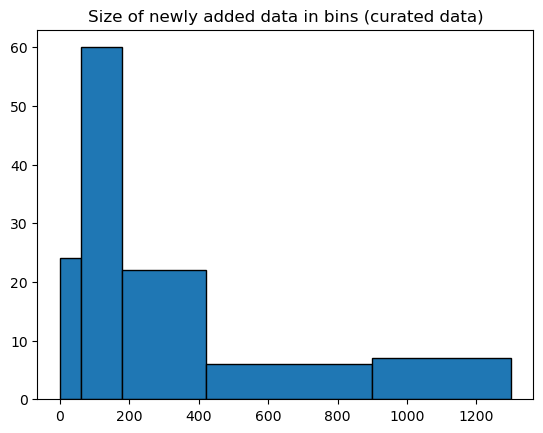

In [70]:
plt.hist(new["length"], bins=[0, 60, 180, 420, 900, 1300], ec="k")
plt.title("Size of newly added data in bins (curated data)")
plt.show()

In [71]:
# conatenate to new df: training data (data supplementation)
train_suppl = pd.concat([train_orig, new])
assert len(train_suppl) == len(train_orig) + len(new_samples)
train_suppl

,tweet,label,lemmas,length
3176,hahaha,0,hahaha,6
1440,user føler svært så prøv flytte afrika så får ...,0,user føle svært så prøve flytte afrika så få s...,68
3501,endnu barriere bønder uden eu,0,endnu barriere bønder uden eu,29
3016,eneste møde ved snuskede stambar aalborg altid...,0,eneste møde ved snusket stambar aalborg altid ...,395
2399,forøvrigt taget godt dokumentarprogram svensk ...,0,forøvrigt tage god dokumentarprogram svensk po...,52
...,...,...,...,...
116,dansk avis oversat kast – knus slimede tøser k...,0,dansk avis oversat kast – knus slimet tøser ki...,58
117,jollivet så fri sjæl så beauvoir ren tøs,0,jollivet så fri sjæl så beauvoir ren tøs,40
118,pokkers tøs amerikansk stumfilm edwin stevens,0,pokkers tøs amerikansk stumfilm edwin stevens,45
119,faktisk lige siden ung tøs så nirvana unplugge...,0,faktisk lige siden ung tøs så nirvana unplugge...,51


In [72]:
# check that distributions are closer to priors now 
print("Prior distributions:")
results_df_1.round(2)

Prior distributions:


bin_range,0-59,60-179,180-419,420-899,900-3519
ALL,12.04,13.86,21.67,35.29,20.0


In [73]:
# prepare and calculate toxicity in length buckets

# # split data
# toxic_text_suppl = train_suppl[train_suppl["label"] == 1]["tweet"]
# nontoxic_text_suppl = train_suppl[train_suppl["label"] == 0]["tweet"]
# all_text_suppl =  train_suppl["tweet"]

# NUM_TOXIC_SUPPL = len(toxic_text_suppl)
# NUM_NONTOXIC_SUPPL = len(nontoxic_text_suppl)
# NUM_TOTAL_SUPPL = len(all_text_suppl)


# divide train data into 6 buckets
print("Min length:", train_suppl["length"].min())
print("Max length:", train_suppl["length"].max())

bin1_suppl = train_suppl.query("0 <= length <= 59") # 60 (orig had 0-19 and 20-59, but difficult to find data under 19 chars)
bin2_suppl = train_suppl.query("60 <= length <= 179") # 120
bin3_suppl = train_suppl.query("180 <= length <= 419") # 240
bin4_suppl = train_suppl.query("420 <= length <= 899") # 480
bin5_suppl = train_suppl.query("900 <= length") # the rest
bins_suppl = [bin1_suppl, bin2_suppl, bin3_suppl, bin4_suppl, bin5_suppl]

# prepare dicts
toxic_count_dict_suppl = {"lemmatized_identity": lemmatized_identities}
total_count_dict_suppl = {"lemmatized_identity": lemmatized_identities}
for label in bin_labels:
    toxic_count_dict_suppl[label] = []
    total_count_dict_suppl[label] = []
    
for lemma in lemmatized_identities: # for each lemma
    for (bin_label, bin) in zip(bin_labels, bins_suppl): # for each bin
        
        # count no. of toxic/all texts this lemma occurs in in this bin
        toxic_count = bin[bin["label"]==1]["lemmas"].apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum() 
        total_count = bin["lemmas"].apply(lambda x: int(occurs_in_string(target=lemma, text=x))).sum() 
        
        # add to count_dicts
        toxic_count_dict_suppl[bin_label].append(toxic_count)
        total_count_dict_suppl[bin_label].append(total_count)

# create df with these occurrence numbers
toxic_count_df_suppl = pd.DataFrame(toxic_count_dict_suppl)
total_count_df_suppl = pd.DataFrame(total_count_dict_suppl)

# map back to actual lemma and aggregate duplicates
toxic_count_df_suppl["lemma"] = toxic_count_df_suppl["lemmatized_identity"].map(lemmatized_2_lemma)
toxic_count_df_suppl = toxic_count_df_suppl.groupby("lemma").agg({"0-59": "sum", "60-179": "sum", "180-419": "sum", "420-899": "sum", "900-3519": "sum"}).reset_index()
toxic_count_df_suppl["sum"] = toxic_count_df_suppl["0-59"] + toxic_count_df_suppl["60-179"] + toxic_count_df_suppl["180-419"] + toxic_count_df_suppl["420-899"] + toxic_count_df_suppl["900-3519"]
toxic_count_df_suppl = toxic_count_df_suppl.sort_values("lemma")
total_count_df_suppl["lemma"] = total_count_df_suppl["lemmatized_identity"].map(lemmatized_2_lemma)
total_count_df_suppl = total_count_df_suppl.groupby("lemma").agg({"0-59": "sum", "60-179": "sum", "180-419": "sum", "420-899": "sum", "900-3519": "sum"}).reset_index()
total_count_df_suppl["sum"] = total_count_df_suppl["0-59"] + total_count_df_suppl["60-179"] + total_count_df_suppl["180-419"] + total_count_df_suppl["420-899"] + total_count_df_suppl["900-3519"]
total_count_df_suppl = total_count_df_suppl.sort_values("lemma")

# add to results df
results_df_3 = toxic_count_df_suppl[["lemma"]]
for col in toxic_count_df_suppl.columns[1:-1]:
    results_df_3[col] = (toxic_count_df_suppl[col] / total_count_df_suppl[col]) * 100 # calculate percentages
results_df_3.set_index("lemma", inplace=True)

Min length: 0
Max length: 3518


In [74]:
print("New distributions")
# show final df
results_df_3.dropna(axis = 0, how = 'all', inplace = True) # drop rows with all NA values
display(results_df_3.round(2).fillna("")) # show results

New distributions


,0-59,60-179,180-419,420-899,900-3519
lemma,,,,,
bedstemor,,,0.0,,
bror,0.0,0.0,0.0,0.0,16.67
dame,,0.0,0.0,,
datter,,0.0,0.0,0.0,0.0
dreng,12.5,0.0,,,0.0
far,0.0,0.0,20.0,,0.0
fyr,,12.5,,,
fætter,0.0,0.0,20.0,0.0,
herre,0.0,0.0,,,0.0


In [ ]:
# # maybe compare to this
# old_new_toxic_frac = old_new_nontoxic_frac_df.copy()
# old_new_toxic_frac["old_f"] = 1 - old_new_toxic_frac["old_f"]
# old_new_toxic_frac["new_f"] = 1 - old_new_toxic_frac["new_f"]
# old_new_toxic_frac.round(2)

### Save new dataset

In [75]:
with open(os.getcwd()+"/data/suppl_dataset_preproc.pkl", "wb") as f:
    pickle.dump(train_suppl, f)

## Control condition (randomly added pages)

In [76]:
# how to get random page:

rd_url = "https://da.wikipedia.org/wiki/Special:Random"

for _ in range(3):
    content = scrape_wiki_text(rd_url)

Successfully scraped the webpage with the title: "Jenny Blicher-Clausen"
Successfully scraped the webpage with the title: "Kurere"
Successfully scraped the webpage with the title: "Rene Szczyrbak"


In [77]:
# find out how much data we need to add of each length

num_random_to_add = {"0-59":0, "60-179":0, "180-419":0, "420-899":0, "900-3519":0}

for (lemma, length) in num_nontoxic_to_add:
    n_add = num_nontoxic_to_add[(lemma, length)]
    num_random_to_add[length] += n_add
    
print(num_random_to_add)
print("Total:", sum(num_random_to_add.values()))

{'0-59': 24, '60-179': 60, '180-419': 22, '420-899': 6, '900-3519': 9}
Total: 121


In [ ]:
# # test something
# num_added = 0
# num_to_add = 3
# while num_added < num_to_add:
    
#     # scrape
#     rd_passages = scrape_wiki_text(rd_url)
#     rd_passage_bank = []
    
#     # preprocess
#     for passage in rd_passages:
#         sentences = []
#         if passage.strip() != "":
#             doc = nlp(passage)
#             for sent in doc.sents:
#                 clean_sent = utils.preprocess(str(sent), stop_words)
#                 if len(clean_sent) > 0:
#                     sentences.append(clean_sent)
#             rd_passage_bank.append(sentences)
    
#     num_added += 1
    
#     # if rnum_addedndom.choice([0,1]) == 1: 
#     #     num_added += 1
#     # print(num_added)

In [78]:
# add random samples (~ 15 minutes)
still_add = num_random_to_add
all_samples = []
iter = 0

while still_add: # while we still need to add more samples
    iter += 1
    print("_"*50)
    print("Iteration:", iter)
    print("_"*50)
    samples, still_add = add_random_of_length(10, still_add)
    all_samples.append(samples)

__________________________________________________
Iteration: 1
__________________________________________________
Successfully scraped the webpage with the title: "Sergi Bruguera"
Successfully scraped the webpage with the title: "Man ooman"
Successfully scraped the webpage with the title: "None"
Successfully scraped the webpage with the title: "In Flames"
Successfully scraped the webpage with the title: "Masahito Noto"
Successfully scraped the webpage with the title: "Nobel (mønt)"
Successfully scraped the webpage with the title: "Nørregaards Teater"
Successfully scraped the webpage with the title: "Free Four"
Successfully scraped the webpage with the title: "FDM travel"
Successfully scraped the webpage with the title: "Ligning"


100%|██████████| 5/5 [00:00<?, ?it/s]


Enough samples. Length: 0-59, number to add: 24, number added: 24
Not enough samples of the correct length within the text bank. Length: 60-179, number to add: 60, number added: 34
Not enough samples of the correct length within the text bank. Length: 180-419, number to add: 22, number added: 10
Not enough samples of the correct length within the text bank. Length: 420-899, number to add: 6, number added: 3
Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 9, number added: 0
__________________________________________________
Iteration: 2
__________________________________________________
Successfully scraped the webpage with the title: "Jesus Kristus i Det Nye Testamente"
Successfully scraped the webpage with the title: "Lille sommerfugl"
Successfully scraped the webpage with the title: "Carl Adolph Feilberg (journalist)"
Successfully scraped the webpage with the title: "Ole Bitsch"
Successfully scraped the webpage with the title: "Risum-Li

100%|██████████| 4/4 [00:00<?, ?it/s]


Enough samples. Length: 60-179, number to add: 26, number added: 26
Enough samples. Length: 180-419, number to add: 12, number added: 12
Enough samples. Length: 420-899, number to add: 3, number added: 3
Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 9, number added: 2
__________________________________________________
Iteration: 3
__________________________________________________
Successfully scraped the webpage with the title: "Shuhei Yomoda"
Successfully scraped the webpage with the title: "Inigo Jones"
Successfully scraped the webpage with the title: "Første klasse"
Successfully scraped the webpage with the title: "Nationalparker i Ukraine"
Successfully scraped the webpage with the title: "Lars Olsen (journalist)"
Successfully scraped the webpage with the title: "Jesper Kunde"
Successfully scraped the webpage with the title: "Blækspruttebrydning"
Successfully scraped the webpage with the title: "Staten Island Greenbelt"
Successfully

100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 7, number added: 0
__________________________________________________
Iteration: 4
__________________________________________________
Successfully scraped the webpage with the title: "Estrid Ott"
Successfully scraped the webpage with the title: "Buck-boost-konverter (ikke-inverterende)"
Successfully scraped the webpage with the title: "71 Nyhavn Hotel"
Successfully scraped the webpage with the title: "Kylie: Live in New York"
Successfully scraped the webpage with the title: "Gitter (ordning)"
Successfully scraped the webpage with the title: "Sorte måne"
Successfully scraped the webpage with the title: "Kill Uncle"
Successfully scraped the webpage with the title: "Sultan (hønserace)"
Successfully scraped the webpage with the title: "Den frie Lærerskole"
Successfully scraped the webpage with the title: "Partia Demokristiane e Shqipërisë"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 7, number added: 1
__________________________________________________
Iteration: 5
__________________________________________________
Successfully scraped the webpage with the title: "VM i håndbold 2011 (mænd)"
Successfully scraped the webpage with the title: "Amanda Knatchbull Ellingworth"
Successfully scraped the webpage with the title: "Love Is Strong"
Successfully scraped the webpage with the title: "Gård fra Halland (Frilandsmuseet)"
Successfully scraped the webpage with the title: "Valerio Agnoli"
Successfully scraped the webpage with the title: "Lei Sufen"
Successfully scraped the webpage with the title: "Dieter Semetzky"
Successfully scraped the webpage with the title: "All-4-Ones diskografi"
Successfully scraped the webpage with the title: "Alpher-Bethe-Gamow-afhandlingen"
Successfully scraped the webpage with the title: "Binyrebark"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 6, number added: 0
__________________________________________________
Iteration: 6
__________________________________________________
Successfully scraped the webpage with the title: "Los Ríos (region)"
Successfully scraped the webpage with the title: "Nørrevang Sogn"
Successfully scraped the webpage with the title: "Herman D. Koppel"
Successfully scraped the webpage with the title: "Dan Lübbers"
Successfully scraped the webpage with the title: "Psykodynamisk psykoterapi"
Successfully scraped the webpage with the title: "Danmarks fiskeriforening"
Successfully scraped the webpage with the title: "Brattingsborg Skov"
Successfully scraped the webpage with the title: "Aarhus Parkour Gathering 2013 Day 4"
Successfully scraped the webpage with the title: "Olympiske lege"
Successfully scraped the webpage with the title: "Mark Wilson"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 6, number added: 0
__________________________________________________
Iteration: 7
__________________________________________________
Successfully scraped the webpage with the title: "Asmild Kloster"
Successfully scraped the webpage with the title: "Marianne Gaarden"
Successfully scraped the webpage with the title: "The Irish Honeymoon"
Successfully scraped the webpage with the title: "Kattarp"
Successfully scraped the webpage with the title: "Postkort fra Mars"
Successfully scraped the webpage with the title: "Alrune Rod"
Successfully scraped the webpage with the title: "Jinnah International Airport"
Successfully scraped the webpage with the title: "Metius (månekrater)"
Successfully scraped the webpage with the title: "Almegårds Kaserne"
Successfully scraped the webpage with the title: "Ivan Denisovitj"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 6, number added: 1
__________________________________________________
Iteration: 8
__________________________________________________
Successfully scraped the webpage with the title: "APG II-systemet"
Successfully scraped the webpage with the title: "Robert Poujade"
Successfully scraped the webpage with the title: "Christian August, pfalzgreve af Pfalz-Sulzbach"
Successfully scraped the webpage with the title: "Julia Pastrana"
Successfully scraped the webpage with the title: "Klæbebinding"
Successfully scraped the webpage with the title: "Terry Moore"
Successfully scraped the webpage with the title: "The Baronets"
Successfully scraped the webpage with the title: "Aursundbroen"
Successfully scraped the webpage with the title: "Fjerntog"
Successfully scraped the webpage with the title: "Flammen & Citronen"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 5, number added: 3
__________________________________________________
Iteration: 9
__________________________________________________
Successfully scraped the webpage with the title: "Gammel Skørping"
Successfully scraped the webpage with the title: "Christian Friedländer"
Successfully scraped the webpage with the title: "Nella Larsen"
Successfully scraped the webpage with the title: "Sam Rockwell"
Successfully scraped the webpage with the title: "Thorkil Vanggaard"
Successfully scraped the webpage with the title: "Korostysjiv"
Successfully scraped the webpage with the title: "Østre Skøjtehal"
Successfully scraped the webpage with the title: "Nowra (New South Wales)"
Successfully scraped the webpage with the title: "Herberg"
Successfully scraped the webpage with the title: "Gadevang Kirke"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 2, number added: 0
__________________________________________________
Iteration: 10
__________________________________________________
Successfully scraped the webpage with the title: "77. østlige længdekreds"
Successfully scraped the webpage with the title: "Serbiens flag"
Successfully scraped the webpage with the title: "John Fante"
Successfully scraped the webpage with the title: "Vendsyssel Tidende"
Successfully scraped the webpage with the title: "Audi 100 C4"
Successfully scraped the webpage with the title: "Die Hard 4.0"
Successfully scraped the webpage with the title: "Aragoniens regenter"
Successfully scraped the webpage with the title: "Bosporus"
Successfully scraped the webpage with the title: "None"
Successfully scraped the webpage with the title: "The Danger Mark"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 2, number added: 0
__________________________________________________
Iteration: 11
__________________________________________________
Successfully scraped the webpage with the title: "Mark Eaton"
Successfully scraped the webpage with the title: "Simmone Jade Mackinnon"
Successfully scraped the webpage with the title: "Et moderne Dækketøjsvaskeri"
Successfully scraped the webpage with the title: "Sarah Glerup"
Successfully scraped the webpage with the title: "De Tre Edsege"
Successfully scraped the webpage with the title: "Mads Andreas Jacobsen"
Successfully scraped the webpage with the title: "Bent Illum"
Successfully scraped the webpage with the title: "Charles Wesley"
Successfully scraped the webpage with the title: "Classica Aldeias do Xisto 2017"
Successfully scraped the webpage with the title: "Bludenz"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 2, number added: 0
__________________________________________________
Iteration: 12
__________________________________________________
Successfully scraped the webpage with the title: "Kallikrateia"
Successfully scraped the webpage with the title: "Ufo"
Successfully scraped the webpage with the title: "DJ Mangoo"
Successfully scraped the webpage with the title: "Within Temptation"
Successfully scraped the webpage with the title: "Amdi Riis"
Successfully scraped the webpage with the title: "Vykrutasy"
Successfully scraped the webpage with the title: "Øster Å"
Successfully scraped the webpage with the title: "Christian Sylow"
Successfully scraped the webpage with the title: "Handelshøjskolen Turība"
Successfully scraped the webpage with the title: "Faramund"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 2, number added: 1
__________________________________________________
Iteration: 13
__________________________________________________
Successfully scraped the webpage with the title: "Jørgen Adolph Grevenkop-Castenskiold"
Successfully scraped the webpage with the title: "Berlins U-Bahn"
Successfully scraped the webpage with the title: "Deutschlandhalle"
Successfully scraped the webpage with the title: "Europa-Parlamentsvalget 2024"
Successfully scraped the webpage with the title: "Almind Sogn (Viborg Kommune)"
Successfully scraped the webpage with the title: "Kritik af Jesus"
Successfully scraped the webpage with the title: "Hadjer-Lamis"
Successfully scraped the webpage with the title: "Sophus Nielsen"
Successfully scraped the webpage with the title: "Charlotte Perrelli"
Successfully scraped the webpage with the title: "Brorsons Sogn"


100%|██████████| 1/1 [00:00<?, ?it/s]


Not enough samples of the correct length within the text bank. Length: 900-3519, number to add: 1, number added: 0
__________________________________________________
Iteration: 14
__________________________________________________
Successfully scraped the webpage with the title: "Grisslehamn"
Successfully scraped the webpage with the title: "Pietro Tacchini"
Successfully scraped the webpage with the title: "Sarah Bernhardt"
Successfully scraped the webpage with the title: "Wuhubroen"
Successfully scraped the webpage with the title: "Zeppelins Nedstyrtning"
Successfully scraped the webpage with the title: "Undvigelseshastighed"
Successfully scraped the webpage with the title: "Metaliferi-bjergene"
Successfully scraped the webpage with the title: "Alkolås"
Successfully scraped the webpage with the title: "Taastrup Realskole"
Successfully scraped the webpage with the title: "None"


100%|██████████| 1/1 [00:00<?, ?it/s]

Enough samples. Length: 900-3519, number to add: 1, number added: 1


In [79]:
# flatten list of new samples
rd_new_samples = [sample for sample_list in all_samples for sample in sample_list]
print(len(rd_new_samples), "random new samples added. Considered", iter*10, "webpages.")

assert len(rd_new_samples) == sum(num_random_to_add.values())
print("\nFive new samples:")
for sample in rd_new_samples[:5]:
    print(" - ", sample)

121 random new samples added. Considered 140 webpages.

Five new samples:
 -  in flames fjerde album colony udgivet juni
 -  feks ab
 -  regnereglerne kan tilsvarende bruges arbejdes uligheder
 -  in flames andet album the jester race udgivet februar
 -  senere hen festivalturné samael grip inc kreator


In [82]:
rd_new = pd.DataFrame(rd_new_samples, columns=["tweet"])
rd_new["label"] = [0]*len(rd_new)
rd_new["length"] = rd_new["tweet"].apply(lambda x: len(x))
rd_new["lemmas"] = rd_new["tweet"].progress_apply(lemmatize_text)
rd_new

100%|██████████| 121/121 [00:27<00:00,  4.43it/s]


,tweet,label,length,lemmas
0,in flames fjerde album colony udgivet juni,0,42,in flame fjerde album colony udgivee juni
1,feks ab,0,7,feks ab
2,regnereglerne kan tilsvarende bruges arbejdes ...,0,55,regnereglerne kunne tilsvarende bruge arbejde ...
3,in flames andet album the jester race udgivet ...,0,53,in flame anden album the jester race udgivee f...
4,senere hen festivalturné samael grip inc kreator,0,48,senere hen festivalturné samael grip inc kreator
...,...,...,...,...
116,bandet allerede udgivet første to udspil soulk...,0,1031,band allerede udgivet første to udspil soulkla...
117,begyndelsen afholdt bandet afskedskoncert aaru...,0,1215,begyndels afholde band afskedskoncert aaruphal...
118,bandet dannet begyndelsen tresserne bestod ban...,0,1156,band danne begyndelsen tresserne bestod band l...
119,ufohændelser per definition forbundet element ...,0,1030,ufohændelse per definition forbunde element uf...


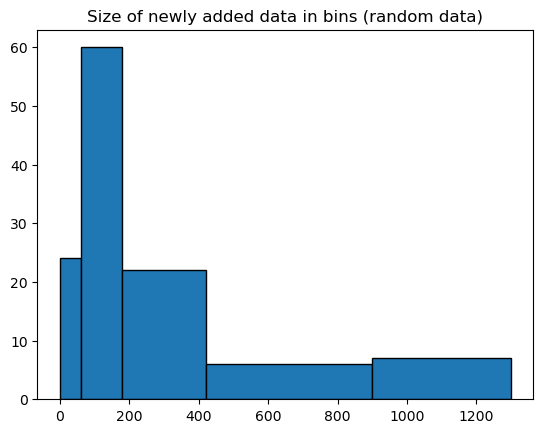

In [83]:
plt.hist(rd_new["length"], bins=[0, 60, 180, 420, 900, 1300], ec="k")
plt.title("Size of newly added data in bins (random data)")
plt.show()

In [84]:
# conatenate to new df: training data (control condition)
train_random = pd.concat([train_orig, rd_new])
assert len(train_random) == len(train_suppl)
train_random

,tweet,label,lemmas,length
3176,hahaha,0,hahaha,6
1440,user føler svært så prøv flytte afrika så får ...,0,user føle svært så prøve flytte afrika så få s...,68
3501,endnu barriere bønder uden eu,0,endnu barriere bønder uden eu,29
3016,eneste møde ved snuskede stambar aalborg altid...,0,eneste møde ved snusket stambar aalborg altid ...,395
2399,forøvrigt taget godt dokumentarprogram svensk ...,0,forøvrigt tage god dokumentarprogram svensk po...,52
...,...,...,...,...
116,bandet allerede udgivet første to udspil soulk...,0,band allerede udgivet første to udspil soulkla...,1031
117,begyndelsen afholdt bandet afskedskoncert aaru...,0,begyndels afholde band afskedskoncert aaruphal...,1215
118,bandet dannet begyndelsen tresserne bestod ban...,0,band danne begyndelsen tresserne bestod band l...,1156
119,ufohændelser per definition forbundet element ...,0,ufohændelse per definition forbunde element uf...,1030


In [85]:
with open(os.getcwd()+"/data/random_dataset_preproc.pkl", "wb") as f:
    pickle.dump(train_random, f)